In [56]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os, gc

import warnings; warnings.filterwarnings('ignore')

In [57]:
user_file_list = os.listdir('Users/')
user_set_v1 = set(map(lambda x: x[5: 15], user_file_list)) # [5: 15] to return just the user IDs

tappy_file_list = os.listdir('TappyData/')
user_set_v2 = set(map(lambda x: x[: 10], tappy_file_list)) # [: 10] to return just the user IDs

user_set = user_set_v1.intersection(user_set_v2)

len(user_set)

217

In [58]:
def read_user_file(file_name):
    f = open('Users/' + file_name)
    data = [line.split(': ')[1][: -1] for line in f.readlines()]
    f.close()

    return data

In [59]:
files = os.listdir('Users/')

columns = [
    'BirthYear', 'Gender', 'Parkinsons', 'Tremors', 'DiagnosisYear',
    'Sided', 'UPDRS', 'Impact', 'Levadopa', 'DA', 'MAOB', 'Other'
]

user_df = pd.DataFrame(columns=columns) # empty Data Frame for now

for user_id in user_set:
    temp_file_name = 'User_' + user_id + '.txt' # tappy file names have the format of `User_[UserID].txt`
    if temp_file_name in files: # check to see if the user ID is in our valid user set
        temp_data = read_user_file(temp_file_name)
        user_df.loc[user_id] = temp_data # adding data to our DataFrame

user_df.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
C6UGS6P0J0,,Male,True,False,,Right,Don't know,Mild,True,False,False,False
E0XRQVF05S,1936,Female,False,False,------,None,Don't know,------,False,False,False,False
MG8XVA5BFA,1942,Female,False,False,------,None,Don't know,------,False,False,False,False
P8HEQZSYJN,1964,Female,True,True,2017,None,Don't know,Medium,True,False,False,False
S9C3TTX3NE,1945,Female,False,False,------,None,Don't know,------,False,False,False,False


In [60]:
pd.value_counts(user_df['Parkinsons'].values)

True     162
False     55
dtype: int64

In [61]:
# force some columns to have numeric data type
user_df['BirthYear'] = pd.to_numeric(user_df['BirthYear'], errors='coerce')
user_df['DiagnosisYear'] = pd.to_numeric(user_df['DiagnosisYear'], errors='coerce')

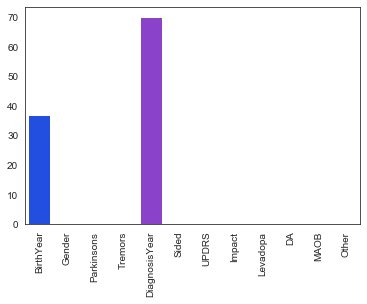

In [62]:
missing_data = user_df.isnull().sum()
sns.set_style('white')
g = sns.barplot(missing_data.index, missing_data,palette='bright')
g.set_xticklabels(labels=missing_data.index, rotation=90)

plt.show()

In [63]:
#user_df = user_df.rename(index=str, columns={'Gender': 'Female'}) # renaming `Gender` to `Female`
#user_df['Female'] = user_df['Female'] == 'Female' # change string data to boolean data
#user_df['Female'] = user_df['Female'].astype(int) # change boolean data to binary data

In [64]:
str_to_bin_columns = ['Parkinsons', 'Tremors', 'Levadopa', 'DA', 'MAOB', 'Other'] # columns to be converted to binary data

for column in str_to_bin_columns:
    user_df[column] = user_df[column] == 'True'
    user_df[column] = user_df[column].astype(int)

In [65]:
# prior processing for `Impact` column
user_df.loc[
    (user_df['Impact'] != 'Medium') &
    (user_df['Impact'] != 'Mild') &
    (user_df['Impact'] != 'Severe'), 'Impact'] = 'None'

to_dummy_column_indices = ['Sided', 'UPDRS', 'Impact'] # columns to be one-hot encoded
for column in to_dummy_column_indices:
    user_df = pd.concat([
        user_df.iloc[:, : user_df.columns.get_loc(column)],
        pd.get_dummies(user_df[column], prefix=str(column)),
        user_df.iloc[:, user_df.columns.get_loc(column) + 1 :]
    ], axis=1)

user_df.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,UPDRS_4,UPDRS_Don't know,Impact_Medium,Impact_Mild,Impact_None,Impact_Severe,Levadopa,DA,MAOB,Other
C6UGS6P0J0,NaN,Male,1,0,NaN,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,0
E0XRQVF05S,1936.0,Female,0,0,NaN,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
MG8XVA5BFA,1942.0,Female,0,0,NaN,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
P8HEQZSYJN,1964.0,Female,1,1,2017.0,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
S9C3TTX3NE,1945.0,Female,0,0,NaN,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0


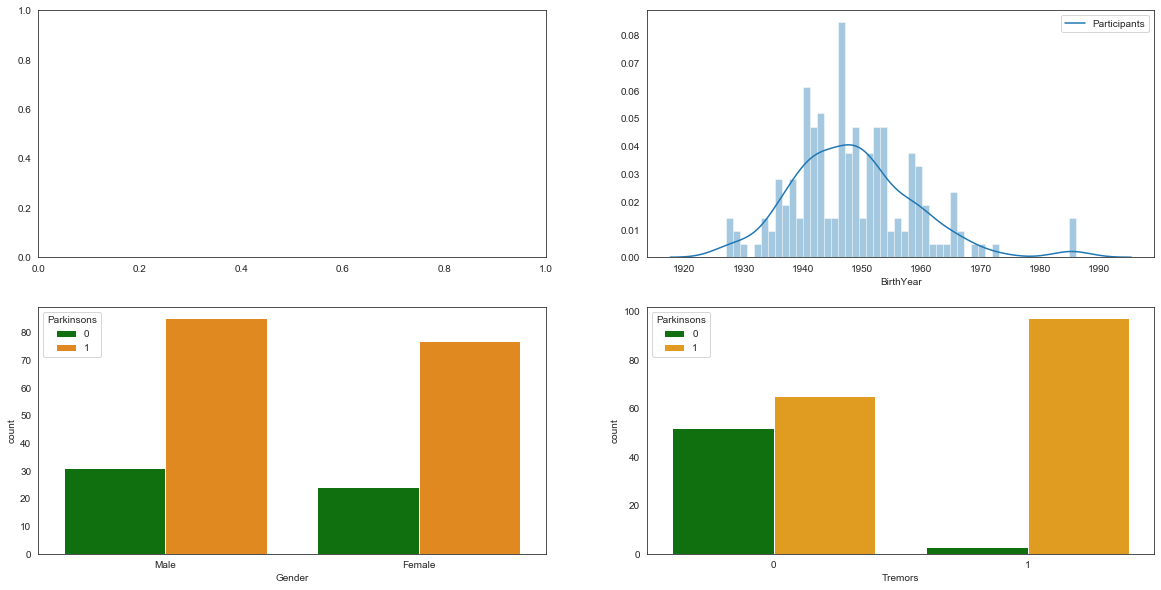

In [66]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_style('white')
# sns.distplot(
#     user_df.loc[user_df['Parkinsons'] == 0, 'BirthYear'].dropna(axis=0),
#     kde_kws = {'label': "Participants Without Parkinson's"},
#     ax = ax[0][0]
# )
# sns.distplot(
#     user_df.loc[user_df['Parkinsons'] == 1, 'BirthYear'].dropna(axis=0),
#     kde_kws = {'label': "Participants With Parkinson's"},
#     ax = ax[0][1]
# )

sns.distplot(
    user_df['BirthYear'].dropna(axis=0),
    kde_kws = {'label': "Participants"},
    ax = ax[0][1], bins=50
)

sns.countplot(x='Gender', hue='Parkinsons', data=user_df, ax=ax[1][0],palette=["green","darkorange"])
sns.countplot(x='Tremors', hue='Parkinsons', data=user_df, ax=ax[1][1],palette=["green","orange"])

plt.show()

In [67]:
user_df.columns

Index(['BirthYear', 'Gender', 'Parkinsons', 'Tremors', 'DiagnosisYear',
       'Sided_Left', 'Sided_None', 'Sided_Right', 'UPDRS_1', 'UPDRS_2',
       'UPDRS_3', 'UPDRS_4', 'UPDRS_Don't know', 'Impact_Medium',
       'Impact_Mild', 'Impact_None', 'Impact_Severe', 'Levadopa', 'DA', 'MAOB',
       'Other'],
      dtype='object')

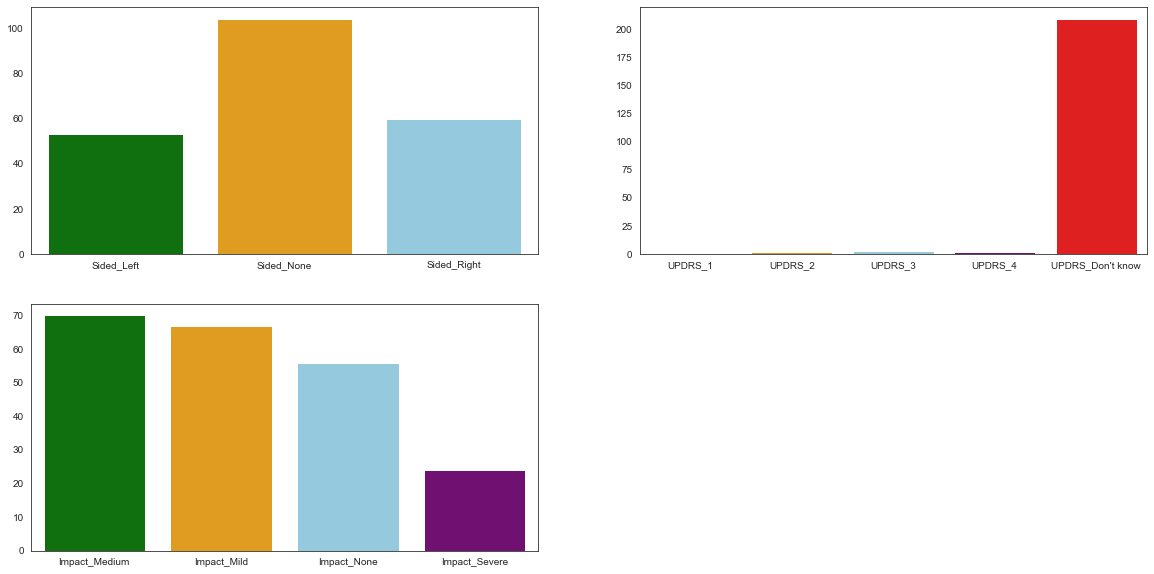

In [68]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(
    ['Sided_Left', 'Sided_None', 'Sided_Right'],
    user_df[['Sided_Left', 'Sided_None', 'Sided_Right']].sum(),palette=["green","orange","skyblue"],
    ax=ax[0][0]
)
sns.barplot(
    ['UPDRS_1', 'UPDRS_2', 'UPDRS_3', 'UPDRS_4', "UPDRS_Don't know"],
    user_df[['UPDRS_1', 'UPDRS_2', 'UPDRS_3', 'UPDRS_4', "UPDRS_Don't know"]].sum(),palette=["green","orange","skyblue","purple","red"],
    ax=ax[0][1]
)
sns.barplot(
    ['Impact_Medium', 'Impact_Mild', 'Impact_None', 'Impact_Severe'],
    user_df[['Impact_Medium', 'Impact_Mild', 'Impact_None', 'Impact_Severe']].sum(),palette=["green","orange","skyblue","purple"],
    ax=ax[1][0]
)
ax[1][1].axis('off')
plt.ylabel='test'
plt.show()

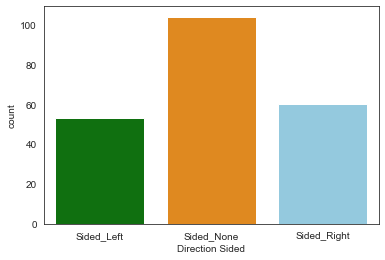

In [69]:
fake = pd.DataFrame({'sided': ['Sided_Left', 'Sided_None', 'Sided_Right'], 'val': user_df[['Sided_Left', 'Sided_None', 'Sided_Right']].sum()})
ax = sns.barplot(x = 'sided', y = 'val', 
              data = fake, 
            palette=["green","darkorange","skyblue","purple"]
            )
ax.set(xlabel='Direction Sided', ylabel='count')
plt.show()


In [70]:
file_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore

In [71]:
df = pd.read_csv(
    'TappyData/' + file_name,
    delimiter = '\t',
    index_col = False,
    names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
)

df = df.drop('UserKey', axis=1)

df.head()

,Date,Timestamp,Hand,Hold time,Direction,Latency time,Flight time
0,160722,18:41:04.336,L,0101.6,LL,0234.4,0156.3
1,160722,18:42:14.070,L,0085.9,LL,0437.5,0359.4
2,160722,18:42:14.273,L,0078.1,LL,0210.9,0125.0
3,160722,18:42:14.617,L,0062.5,LL,0359.4,0281.3
4,160722,18:42:15.586,S,0125.0,LS,0187.5,0093.8


In [72]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date
# converting time data to numeric
for column in ['Hold time', 'Latency time', 'Flight time']:
    df[column] = pd.to_numeric(df[column], errors='coerce')

df = df.dropna(axis=0)

In [73]:
# cleaning data in Hand
df = df[
    (df['Hand'] == 'L') |
    (df['Hand'] == 'R') |
    (df['Hand'] == 'S')
]

# cleaning data in Direction
df = df[
    (df['Direction'] == 'LL') |
    (df['Direction'] == 'LR') |
    (df['Direction'] == 'LS') |
    (df['Direction'] == 'RL') |
    (df['Direction'] == 'RR') |
    (df['Direction'] == 'RS') |
    (df['Direction'] == 'SL') |
    (df['Direction'] == 'SR') |
    (df['Direction'] == 'SS')
]

In [74]:
direction_group_df = df.groupby('Direction').mean()
direction_group_df

,Hold time,Latency time,Flight time
Direction,,,
LL,81.897585,263.693681,184.458003
LR,81.563368,277.280266,210.061092
LS,113.614473,204.752122,121.226882
RL,74.481909,417.072856,340.956823
RR,79.109145,275.253268,205.742761
RS,115.448340,233.403863,150.378538
SL,69.692995,346.412846,233.743770
SR,75.492281,345.973700,235.207990
SS,84.336522,141.706087,73.095217


In [75]:
def read_tappy(file_name):
    df = pd.read_csv(
        'TappyData/' + file_name,
        delimiter = '\t',
        index_col = False,
        names = ['UserKey', 'Date', 'Timestamp', 'Hand', 'Hold time', 'Direction', 'Latency time', 'Flight time']
    )

    df = df.drop('UserKey', axis=1)

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', format='%y%M%d').dt.date

    # converting time data to numeric
    #print(df[df['Hold time'] == '0105.0EA27ICBLF']) # for 0EA27ICBLF_1607.txt
    for column in ['Hold time', 'Latency time', 'Flight time']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(axis=0)

    # cleaning data in Hand
    df = df[
        (df['Hand'] == 'L') |
        (df['Hand'] == 'R') |
        (df['Hand'] == 'S')
    ]

    # cleaning data in Direction
    df = df[
        (df['Direction'] == 'LL') |
        (df['Direction'] == 'LR') |
        (df['Direction'] == 'LS') |
        (df['Direction'] == 'RL') |
        (df['Direction'] == 'RR') |
        (df['Direction'] == 'RS') |
        (df['Direction'] == 'SL') |
        (df['Direction'] == 'SR') |
        (df['Direction'] == 'SS')
    ]

    direction_group_df = df.groupby('Direction').mean()
    del df; gc.collect()
    direction_group_df = direction_group_df.reindex(['LL', 'LR', 'LS', 'RL', 'RR', 'RS', 'SL', 'SR', 'SS'])
    direction_group_df = direction_group_df.sort_index() # to ensure correct order of data
    
    return direction_group_df.values.flatten() # returning a numppy array

In [76]:
file_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore
tappy_data = read_tappy(file_name)

tappy_data # which corresponds to the DataFrame above in orderfile_name = '0EA27ICBLF_1607.txt' # an arbitrary file to explore

array([ 81.89758471, 263.69368078, 184.45800252,  81.56336806,
       277.2802662 , 210.06109182, 113.61447334, 204.75212158,
       121.22688219,  74.48190853, 417.07285573, 340.95682257,
        79.10914471, 275.25326842, 205.7427613 , 115.44834027,
       233.40386281, 150.37853808,  69.69299483, 346.41284554,
       233.74376999,  75.49228061, 345.97369989, 235.20799025,
        84.33652174, 141.70608696,  73.09521739])

In [77]:
def process_user(user_id, filenames):
    running_user_data = np.array([])

    for filename in filenames:
        if user_id in filename:
            running_user_data = np.append(running_user_data, read_tappy(filename))
    
    running_user_data = np.reshape(running_user_data, (-1, 27))
    return np.nanmean(running_user_data, axis=0) # ignoring NaNs while calculating the mean

In [78]:
filenames = os.listdir('TappyData/')

user_id = '0EA27ICBLF'
process_user(user_id, filenames)

array([ 83.23554563, 263.16479813, 182.42601437,  83.45694088,
       278.91128036, 210.43491235, 115.3738097 , 210.23147813,
       125.82658315,  75.55503123, 415.84500069, 337.78674056,
        79.97841961, 268.74304632, 198.41750457, 117.11041434,
       240.05455891, 156.57543596,  70.34764932, 345.50649477,
       230.85896203,  76.41035083, 338.3596131 , 226.28202144,
        85.38042303, 158.02331375,  84.87598707])

In [79]:
column_names = [first_hand + second_hand + '_' + time for first_hand in ['L', 'R', 'S'] for second_hand in ['L', 'R', 'S'] for time in ['Hold time', 'Latency time', 'Flight time']]

user_tappy_df = pd.DataFrame(columns=column_names)

for user_id in user_df.index:
    user_tappy_data = process_user(str(user_id), filenames)
    user_tappy_df.loc[user_id] = user_tappy_data

# some preliminary data cleaning
user_tappy_df = user_tappy_df.fillna(0)
user_tappy_df[user_tappy_df < 0] = 0    

user_tappy_df.head()

,LL_Hold time,LL_Latency time,LL_Flight time,LR_Hold time,LR_Latency time,LR_Flight time,LS_Hold time,LS_Latency time,LS_Flight time,RL_Hold time,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
C6UGS6P0J0,123.657628,250.291437,177.077557,142.787973,188.700343,151.612051,126.396108,228.550419,127.605016,127.554907,...,157.425374,98.140925,189.612224,184.790574,99.489502,200.429856,182.415968,290.804680,218.381019,114.523164
E0XRQVF05S,153.650000,395.183333,258.466667,109.375000,480.500000,442.400000,0.000000,0.000000,0.000000,165.640000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MG8XVA5BFA,103.083672,181.294707,121.381364,99.010011,140.930631,105.847202,98.128351,169.337177,96.172853,98.557912,...,111.025878,91.716503,159.168252,113.208541,96.395320,165.084256,115.647464,120.828677,246.564490,137.177865
P8HEQZSYJN,108.409204,359.725746,260.703109,104.640595,304.914750,201.458999,123.335943,330.528114,212.893594,108.875789,...,241.446012,109.396800,469.828400,356.544800,109.336957,485.551449,372.526087,104.447826,322.860870,214.495652
S9C3TTX3NE,106.966692,204.812228,128.498650,104.810882,201.314608,131.731961,111.552555,194.417518,100.045985,108.122647,...,164.504396,102.088618,202.277236,152.458537,108.227907,229.283721,162.296512,92.060000,173.585000,91.720000


In [80]:
combined_user_df = pd.concat([user_df, user_tappy_df], axis=1)
combined_user_df.head()

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,RS_Flight time,SL_Hold time,SL_Latency time,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time
C6UGS6P0J0,NaN,Male,1,0,NaN,0,0,1,0,0,...,157.425374,98.140925,189.612224,184.790574,99.489502,200.429856,182.415968,290.804680,218.381019,114.523164
E0XRQVF05S,1936.0,Female,0,0,NaN,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MG8XVA5BFA,1942.0,Female,0,0,NaN,0,1,0,0,0,...,111.025878,91.716503,159.168252,113.208541,96.395320,165.084256,115.647464,120.828677,246.564490,137.177865
P8HEQZSYJN,1964.0,Female,1,1,2017.0,0,1,0,0,0,...,241.446012,109.396800,469.828400,356.544800,109.336957,485.551449,372.526087,104.447826,322.860870,214.495652
S9C3TTX3NE,1945.0,Female,0,0,NaN,0,1,0,0,0,...,164.504396,102.088618,202.277236,152.458537,108.227907,229.283721,162.296512,92.060000,173.585000,91.720000


In [81]:
col = combined_user_df[['LL_Hold time','LR_Hold time','LS_Hold time','RL_Hold time','RR_Hold time','RS_Hold time','SL_Hold time','SR_Hold time','SS_Hold time']]

#col = combined_user_df[['SS_Hold time','SR_Hold time']]

# combined_user_df.mean(axis=1)
combined_user_df['holdtime_mean'] = col.mean(axis=1)
combined_user_df

col = combined_user_df[['LL_Flight time','LR_Flight time','LS_Flight time','RL_Flight time','RR_Flight time','RS_Flight time','SL_Flight time','SR_Flight time','SS_Flight time']]
combined_user_df['flighttime_mean'] = col.mean(axis=1)
combined_user_df

col = combined_user_df[['LL_Latency time','LR_Latency time','LS_Latency time','RL_Latency time','RR_Latency time','RS_Latency time','SL_Latency time','SR_Latency time','SS_Latency time']]
combined_user_df['latencytime_mean'] = col.mean(axis=1)
combined_user_df

,BirthYear,Gender,Parkinsons,Tremors,DiagnosisYear,Sided_Left,Sided_None,Sided_Right,UPDRS_1,UPDRS_2,...,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time,holdtime_mean,flighttime_mean,latencytime_mean
C6UGS6P0J0,NaN,Male,1,0,NaN,0,0,1,0,0,...,184.790574,99.489502,200.429856,182.415968,290.804680,218.381019,114.523164,138.872739,155.516192,219.435161
E0XRQVF05S,1936.0,Female,0,0,NaN,0,1,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.629444,112.338519,136.447037
MG8XVA5BFA,1942.0,Female,0,0,NaN,0,1,0,0,0,...,113.208541,96.395320,165.084256,115.647464,120.828677,246.564490,137.177865,101.555817,113.275227,176.975417
P8HEQZSYJN,1964.0,Female,1,1,2017.0,0,1,0,0,0,...,356.544800,109.336957,485.551449,372.526087,104.447826,322.860870,214.495652,110.537011,272.012122,377.443980
S9C3TTX3NE,1945.0,Female,0,0,NaN,0,1,0,0,0,...,152.458537,108.227907,229.283721,162.296512,92.060000,173.585000,91.720000,106.264742,131.348814,207.884691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UUIZH9TDXR,1958.0,Female,1,0,2015.0,1,0,0,0,0,...,412.726685,194.990293,639.322069,403.426264,274.643426,587.838292,329.879463,224.916653,400.520353,613.177370
YWMIQIQND3,1953.0,Female,1,1,2016.0,0,0,1,0,0,...,115.347059,140.878125,354.993750,274.784375,139.322222,281.255556,159.733333,131.149194,187.842085,297.032517
9GBSZXI2BB,NaN,Female,1,1,2014.0,0,0,1,0,0,...,320.988397,154.721092,557.736613,386.772933,154.617127,335.556643,191.418947,163.021879,325.872802,479.015218
UDCY90VKYN,1938.0,Male,1,0,2016.0,1,0,0,0,0,...,240.014824,102.951007,304.901269,243.615697,59.550000,140.291667,218.433333,108.493078,176.189214,235.276945


['LL_Hold time', 'LL_Latency time', 'LL_Flight time']
['LR_Hold time', 'LR_Latency time', 'LR_Flight time']
['LS_Hold time', 'LS_Latency time', 'LS_Flight time']
['RL_Hold time', 'RL_Latency time', 'RL_Flight time']
['RR_Hold time', 'RR_Latency time', 'RR_Flight time']
['RS_Hold time', 'RS_Latency time', 'RS_Flight time']
['SL_Hold time', 'SL_Latency time', 'SL_Flight time']
['SR_Hold time', 'SR_Latency time', 'SR_Flight time']
['SS_Hold time', 'SS_Latency time', 'SS_Flight time']


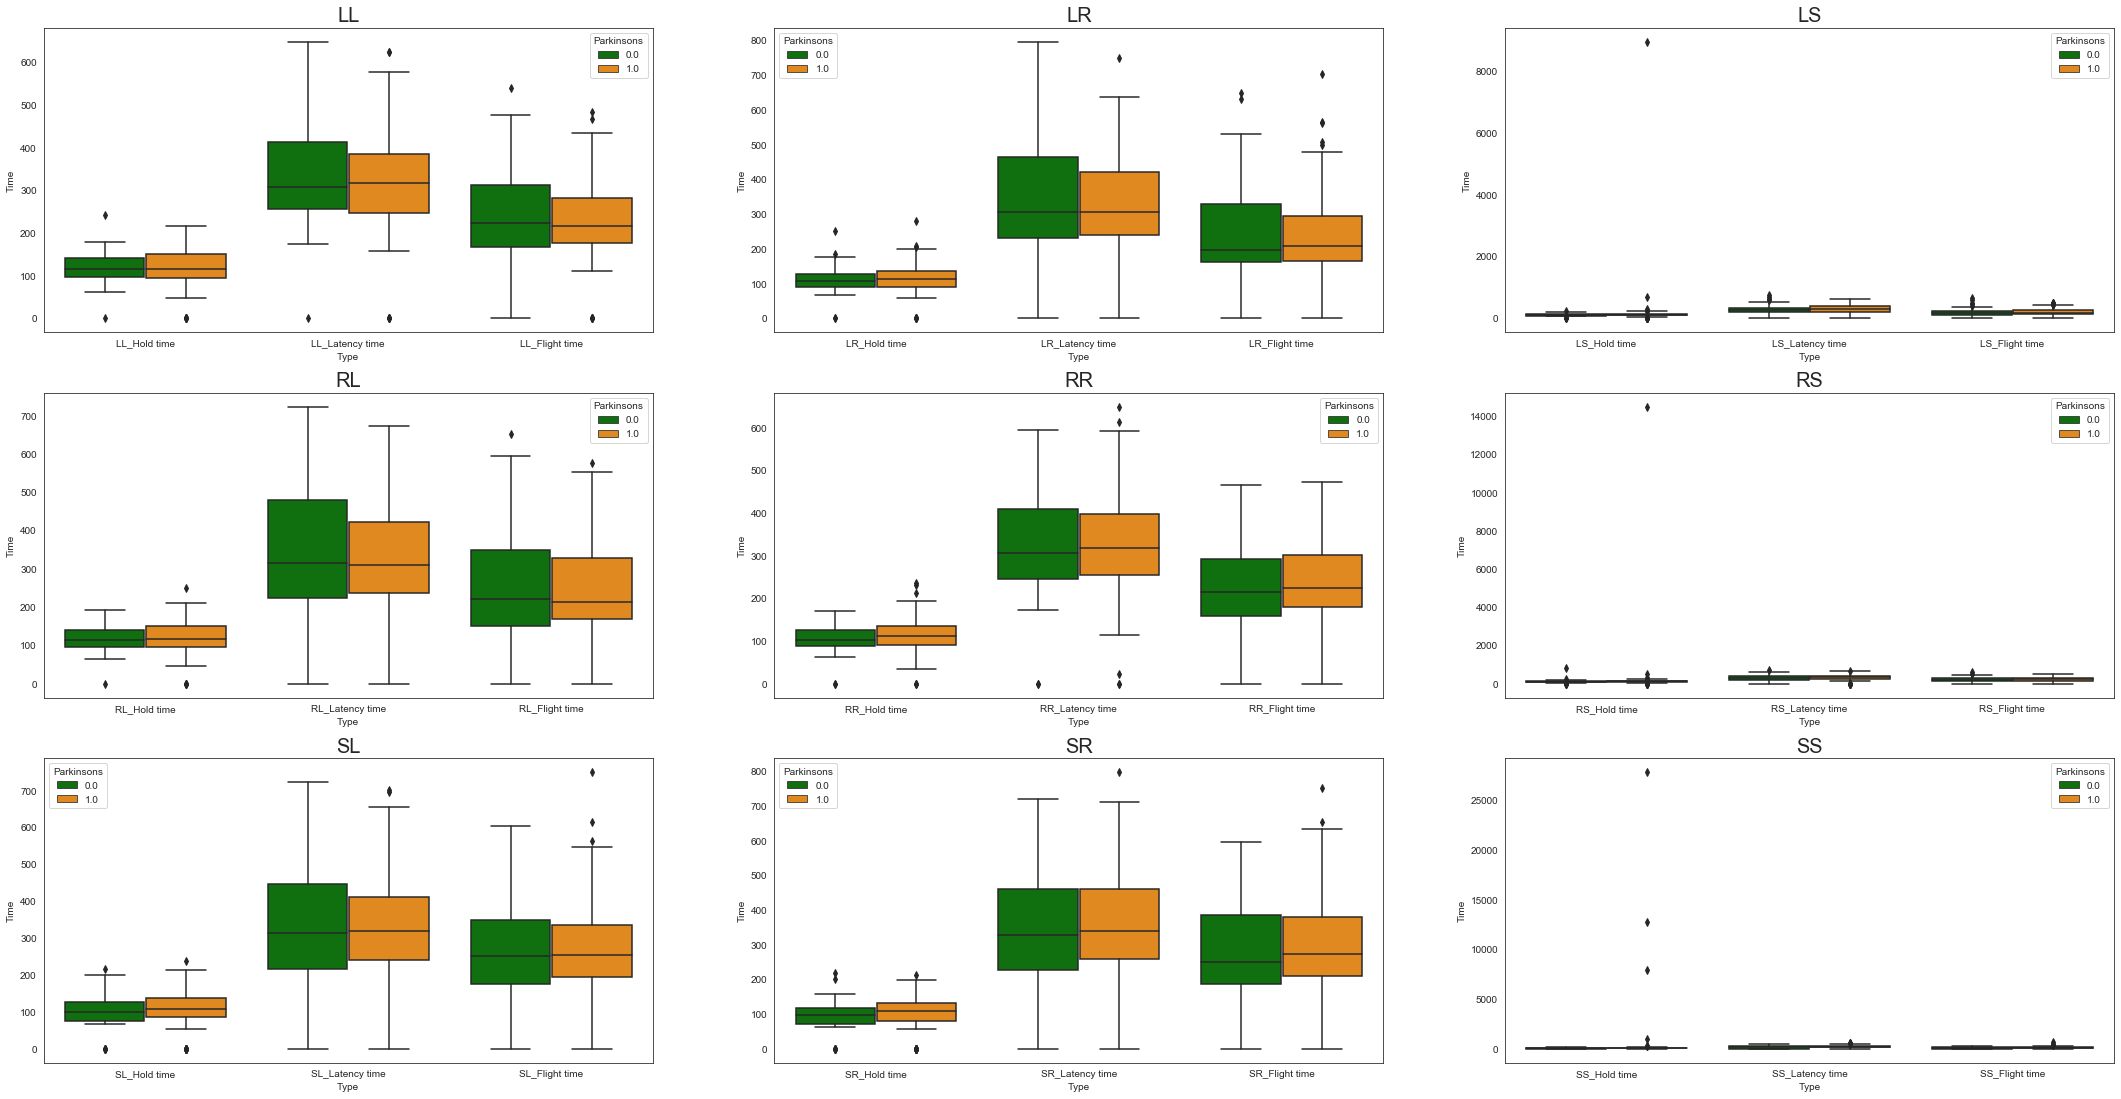

In [82]:
f, ax = plt.subplots(3, 3, figsize=(10, 5))
#f.tight_layout()
plt.subplots_adjust(
    #left  = 0.5,
    right = 3,
    #bottom = 0.5,
    top = 3,
)

for i in range(9):
    temp_columns = column_names[3 * i : 3 * i + 3]
    print(temp_columns)
    stacked_df = combined_user_df[temp_columns].stack().reset_index()
    
    stacked_df = stacked_df.rename(columns={'level_0': 'index', 'level_1': 'Type', 0: 'Time'})
    stacked_df = stacked_df.set_index('index')

    for index in stacked_df.index:
        stacked_df.loc[index, 'Parkinsons'] = combined_user_df.loc[index, 'Parkinsons']
    
    sns.boxplot(x='Type', y='Time', hue='Parkinsons', data=stacked_df, ax=ax[i // 3][i % 3],palette=["green","darkorange"]).set_title(column_names[i * 3][: 2], fontsize=20)
    
plt.show()

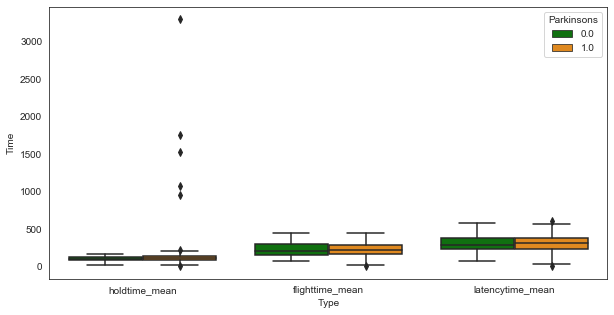

In [83]:
f, ax = plt.subplots(figsize=(10, 5))


temp_columns = ['holdtime_mean','flighttime_mean','latencytime_mean']
stacked_df = combined_user_df[temp_columns].stack().reset_index()
    
stacked_df = stacked_df.rename(columns={'level_0': 'index', 'level_1': 'Type', 0: 'Time'})
stacked_df = stacked_df.set_index('index')

for index in stacked_df.index:
    stacked_df.loc[index, 'Parkinsons'] = combined_user_df.loc[index, 'Parkinsons']

sns.boxplot(x='Type', y='Time', hue='Parkinsons', data=stacked_df, ax=ax, palette=["green","darkorange"])
    
plt.show()

In [84]:
user_set

{'0EA27ICBLF',
 '0QAZFRHQHW',
 '1HOEBIGASW',
 '1XNJCXS3EY',
 '2JTCBKUP8T',
 '2X17VCRRQA',
 '310NXPGJPD',
 '39KQRZCESF',
 '3DIXPRIOSW',
 '3MZWDTW7CC',
 '48DZPAJ5NS',
 '4GUYFBZMK9',
 '4XPHKKBXS6',
 '5ARV4LHEJ0',
 '5PQVTWULAC',
 '5USOYSDCXB',
 '5YFAPLRCMD',
 '6LB9FQABZQ',
 '6R9IGYWVWT',
 '6WBXSDG5BB',
 '6YXFEMHYZI',
 '7HTEQAAWWO',
 '7QVQD5IJEH',
 '7XS9VOLXWU',
 '81NEUZEBXI',
 '8EY6NZAKCI',
 '8MERXVINPN',
 '8O9IAIA9L1',
 '8TEUUGQBYB',
 '927ZLCPEJM',
 '95S93AXF86',
 '9GBSZXI2BB',
 '9JRHCGCWAZ',
 '9RCEHVGNCJ',
 '9TUXDIR9EE',
 '9ZRBC5WOZR',
 'ACSKCOJC06',
 'AFNOZ1KI1M',
 'AFQWSP8ARK',
 'AJHHNPKG0K',
 'AJIGSB2YPW',
 'ARUGT4UL2R',
 'ASP8RSNO73',
 'AVNGRDUXE5',
 'AXXXXBBCCH',
 'B4NL4SV9ZC',
 'BBCWCBNBPR',
 'BENXJNDSC4',
 'BFXNVL50DC',
 'BIGWMXFU3B',
 'BZ8MQ2TBMS',
 'C6UGS6P0J0',
 'CAXCJIKLYM',
 'CEU6KM05RU',
 'COK8G1W7JY',
 'CPSM4LIXDS',
 'CYC6IZJYTE',
 'E0TBSMYHQI',
 'E0XRQVF05S',
 'E1E2I8HUGC',
 'E7UA8EHENF',
 'EBGLZDVO5S',
 'EF9XEFXPBN',
 'EKG57AN0N6',
 'EMYGMAIB2L',
 'ERFIZ5O8FM',
 'EX8J9DGR

In [85]:
combined_user_df.columns

Index(['BirthYear', 'Gender', 'Parkinsons', 'Tremors', 'DiagnosisYear',
       'Sided_Left', 'Sided_None', 'Sided_Right', 'UPDRS_1', 'UPDRS_2',
       'UPDRS_3', 'UPDRS_4', 'UPDRS_Don't know', 'Impact_Medium',
       'Impact_Mild', 'Impact_None', 'Impact_Severe', 'Levadopa', 'DA', 'MAOB',
       'Other', 'LL_Hold time', 'LL_Latency time', 'LL_Flight time',
       'LR_Hold time', 'LR_Latency time', 'LR_Flight time', 'LS_Hold time',
       'LS_Latency time', 'LS_Flight time', 'RL_Hold time', 'RL_Latency time',
       'RL_Flight time', 'RR_Hold time', 'RR_Latency time', 'RR_Flight time',
       'RS_Hold time', 'RS_Latency time', 'RS_Flight time', 'SL_Hold time',
       'SL_Latency time', 'SL_Flight time', 'SR_Hold time', 'SR_Latency time',
       'SR_Flight time', 'SS_Hold time', 'SS_Latency time', 'SS_Flight time',
       'holdtime_mean', 'flighttime_mean', 'latencytime_mean'],
      dtype='object')

In [86]:
pk_df = combined_user_df[combined_user_df.Parkinsons==1]
print(pk_df['holdtime_mean'].median())
print(pk_df['flighttime_mean'].median())
print(pk_df['latencytime_mean'].median())

113.24345034365129
215.98852866594
309.1012966965458


In [87]:
nonpk_df = combined_user_df[combined_user_df.Parkinsons==0]
print(nonpk_df['holdtime_mean'].median())
print(nonpk_df['flighttime_mean'].median())
print(nonpk_df['latencytime_mean'].median())

107.22255281142614
208.7595655970543
287.48703396083346


In [88]:
combined_user_df['ST_label'] = np.where(np.logical_or(np.logical_or(combined_user_df['holdtime_mean']>=108, combined_user_df['flighttime_mean']>=209), combined_user_df['latencytime_mean']>=288), 1, 0)


In [89]:
from sklearn.metrics import accuracy_score
accuracy_score(combined_user_df['Parkinsons'], combined_user_df['ST_label'])

0.6589861751152074

In [90]:
combined_user_df = combined_user_df.drop('ST_label',axis=1)

In [91]:
# Drop the target from the training data


df_all_labels = combined_user_df['Parkinsons']
#Drop columns
columns_usersdata = ["BirthYear", "Gender", "Parkinsons", "Tremors", "DiagnosisYear",
       "Sided_Left", "Sided_None", "Sided_Right", "UPDRS_1", "UPDRS_2",
       "UPDRS_3", "UPDRS_4", "UPDRS_Don't know", "Impact_Medium",
       "Impact_Mild", "Impact_None", "Impact_Severe", "Levadopa", "DA", "MAOB",
       "Other"]
#df_all_data = combined_user_df.drop(columns = ['Parkinsons'])
df_all_data = combined_user_df.drop(columns_usersdata, axis=1)

df_all_data.columns

Index(['LL_Hold time', 'LL_Latency time', 'LL_Flight time', 'LR_Hold time',
       'LR_Latency time', 'LR_Flight time', 'LS_Hold time', 'LS_Latency time',
       'LS_Flight time', 'RL_Hold time', 'RL_Latency time', 'RL_Flight time',
       'RR_Hold time', 'RR_Latency time', 'RR_Flight time', 'RS_Hold time',
       'RS_Latency time', 'RS_Flight time', 'SL_Hold time', 'SL_Latency time',
       'SL_Flight time', 'SR_Hold time', 'SR_Latency time', 'SR_Flight time',
       'SS_Hold time', 'SS_Latency time', 'SS_Flight time', 'holdtime_mean',
       'flighttime_mean', 'latencytime_mean'],
      dtype='object')

In [92]:
df_all_data

,LL_Hold time,LL_Latency time,LL_Flight time,LR_Hold time,LR_Latency time,LR_Flight time,LS_Hold time,LS_Latency time,LS_Flight time,RL_Hold time,...,SL_Flight time,SR_Hold time,SR_Latency time,SR_Flight time,SS_Hold time,SS_Latency time,SS_Flight time,holdtime_mean,flighttime_mean,latencytime_mean
C6UGS6P0J0,123.657628,250.291437,177.077557,142.787973,188.700343,151.612051,126.396108,228.550419,127.605016,127.554907,...,184.790574,99.489502,200.429856,182.415968,290.804680,218.381019,114.523164,138.872739,155.516192,219.435161
E0XRQVF05S,153.650000,395.183333,258.466667,109.375000,480.500000,442.400000,0.000000,0.000000,0.000000,165.640000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.629444,112.338519,136.447037
MG8XVA5BFA,103.083672,181.294707,121.381364,99.010011,140.930631,105.847202,98.128351,169.337177,96.172853,98.557912,...,113.208541,96.395320,165.084256,115.647464,120.828677,246.564490,137.177865,101.555817,113.275227,176.975417
P8HEQZSYJN,108.409204,359.725746,260.703109,104.640595,304.914750,201.458999,123.335943,330.528114,212.893594,108.875789,...,356.544800,109.336957,485.551449,372.526087,104.447826,322.860870,214.495652,110.537011,272.012122,377.443980
S9C3TTX3NE,106.966692,204.812228,128.498650,104.810882,201.314608,131.731961,111.552555,194.417518,100.045985,108.122647,...,152.458537,108.227907,229.283721,162.296512,92.060000,173.585000,91.720000,106.264742,131.348814,207.884691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UUIZH9TDXR,206.084093,624.379596,435.299902,206.702614,607.937309,394.530104,250.929475,616.468878,407.678623,210.419308,...,412.726685,194.990293,639.322069,403.426264,274.643426,587.838292,329.879463,224.916653,400.520353,613.177370
YWMIQIQND3,103.366013,249.626144,158.630065,141.265306,262.962245,177.938776,144.539623,255.386792,164.807547,104.287387,...,115.347059,140.878125,354.993750,274.784375,139.322222,281.255556,159.733333,131.149194,187.842085,297.032517
9GBSZXI2BB,154.037059,463.732335,328.858714,146.419314,518.982649,356.140641,202.322849,454.841309,303.441788,155.867396,...,320.988397,154.721092,557.736613,386.772933,154.617127,335.556643,191.418947,163.021879,325.872802,479.015218
UDCY90VKYN,119.222142,242.293509,150.755325,106.442671,220.176536,154.406531,131.933725,209.446096,113.165819,115.768260,...,240.014824,102.951007,304.901269,243.615697,59.550000,140.291667,218.433333,108.493078,176.189214,235.276945


In [93]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer

features = list(df_all_data.columns)

# Median imputation of missing values

imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1

scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data

imputer.fit(df_all_data)

# Transform all the data

df_all_data = imputer.transform(df_all_data)

# Repeat with the scaler

scaler.fit(df_all_data)

df_all_data = scaler.transform(df_all_data)

In [94]:
from sklearn.model_selection import train_test_split

df_train, df_test, df_train_labels, df_test_labels = train_test_split(df_all_data, df_all_labels, test_size=0.3, random_state=42)


print('Training data shape: ', df_train.shape)

print('Testing data shape: ', df_test.shape)

print('Training data labels shape: ', df_train_labels.shape)

print('Testing data labels shape: ', df_test_labels.shape)

Training data shape:  (151, 30)
Testing data shape:  (66, 30)
Training data labels shape:  (151,)
Testing data labels shape:  (66,)


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf_lr = LogisticRegression()
clf_lr.fit(df_train, df_train_labels)
pred_lr = clf_lr.predict(df_test)
from sklearn.metrics import confusion_matrix
#confusion_matrix(df_test_labels, pred_lr)
accuracy_score(df_test_labels, pred_lr)

0.7424242424242424

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf_rfc = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
clf_rfc.fit(df_train, df_train_labels)
pred_rfc = clf_rfc.predict(df_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(df_test_labels, pred_rfc)
accuracy_score(df_test_labels, pred_rfc)

0.7272727272727273

In [97]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42, tol=1e-5)
clf.fit(df_train, df_train_labels)  
pred = clf.predict(df_test)
from sklearn.metrics import accuracy_score
accuracy_score(df_test_labels, pred)

0.7121212121212122

In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df_test_labels, pred)

array([[ 2, 16],
       [ 3, 45]], dtype=int64)

In [99]:
print(clf_lr.coef_)

[[ 5.53113815e-04 -7.01314264e-01 -5.36423507e-01  3.57550532e-01
  -1.32721708e-01 -1.66536624e-01  2.68804431e-01  8.65735420e-02
   3.11578324e-01  4.90492782e-01 -5.72958276e-01 -4.33115005e-01
   5.97388481e-01  1.89021630e-01  3.13251377e-01  1.45096029e-01
   3.75366926e-01  2.82027850e-01  4.08140585e-01  2.97829029e-02
   2.46698392e-01  8.83704536e-02 -1.10476657e-01 -3.41166940e-02
   2.12346113e-01  2.04189288e-01  1.75158596e-01  3.67642958e-01
   2.33643255e-02 -8.86359924e-02]]


In [120]:
#from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=15):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    print(top_positive_coefficients)
    print(top_negative_coefficients)
    print(top_coefficients)
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0.17, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title('Feature Importance',fontsize=19)
    plt.xlabel("Features",fontsize=14)
    plt.show()


['LL_Hold time', 'LL_Latency time', 'LL_Flight time', 'LR_Hold time', 'LR_Latency time', 'LR_Flight time', 'LS_Hold time', 'LS_Latency time', 'LS_Flight time', 'RL_Hold time', 'RL_Latency time', 'RL_Flight time', 'RR_Hold time', 'RR_Latency time', 'RR_Flight time', 'RS_Hold time', 'RS_Latency time', 'RS_Flight time', 'SL_Hold time', 'SL_Latency time', 'SL_Flight time', 'SR_Hold time', 'SR_Latency time', 'SR_Flight time', 'SS_Hold time', 'SS_Latency time', 'SS_Flight time', 'holdtime_mean', 'flighttime_mean', 'latencytime_mean']
[26 13 25 24 20  6 17  8 14  3 27 16 18  9 12]
[ 1 10  2 11  5  4 22 29 23  0 28 19  7 21 15]
[ 1 10  2 11  5  4 22 29 23  0 28 19  7 21 15 26 13 25 24 20  6 17  8 14
  3 27 16 18  9 12]


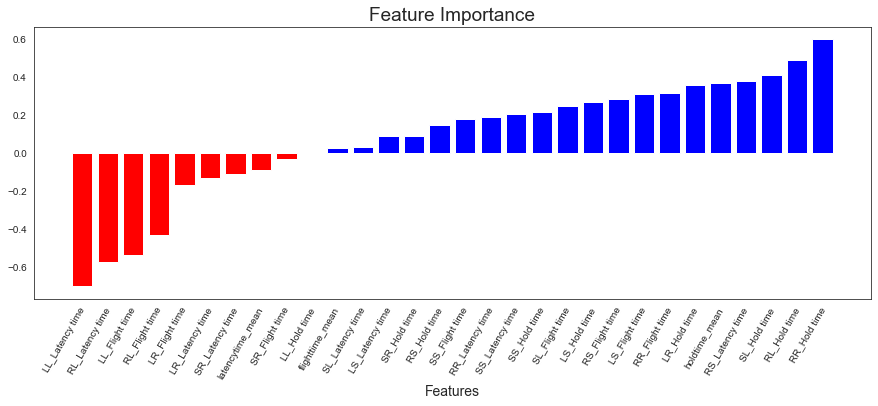

In [121]:
print(features)
plot_coefficients(clf_lr, features)


In [102]:
clf_lr.coef_

array([[ 5.53113815e-04, -7.01314264e-01, -5.36423507e-01,
         3.57550532e-01, -1.32721708e-01, -1.66536624e-01,
         2.68804431e-01,  8.65735420e-02,  3.11578324e-01,
         4.90492782e-01, -5.72958276e-01, -4.33115005e-01,
         5.97388481e-01,  1.89021630e-01,  3.13251377e-01,
         1.45096029e-01,  3.75366926e-01,  2.82027850e-01,
         4.08140585e-01,  2.97829029e-02,  2.46698392e-01,
         8.83704536e-02, -1.10476657e-01, -3.41166940e-02,
         2.12346113e-01,  2.04189288e-01,  1.75158596e-01,
         3.67642958e-01,  2.33643255e-02, -8.86359924e-02]])

In [122]:
def plot_coefficients_absolute(classifier, feature_names, top_features=15):
    coef = classifier.coef_.ravel()
    coef = abs(coef)
    top_coefficients = np.argsort(coef)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0.17,1 + top_features), feature_names[top_coefficients], rotation=60,ha='right')
    plt.title('Feature Importance',fontsize=19)
    plt.xlabel('Features',fontsize=14)
    plt.show()

['LL_Hold time', 'LL_Latency time', 'LL_Flight time', 'LR_Hold time', 'LR_Latency time', 'LR_Flight time', 'LS_Hold time', 'LS_Latency time', 'LS_Flight time', 'RL_Hold time', 'RL_Latency time', 'RL_Flight time', 'RR_Hold time', 'RR_Latency time', 'RR_Flight time', 'RS_Hold time', 'RS_Latency time', 'RS_Flight time', 'SL_Hold time', 'SL_Latency time', 'SL_Flight time', 'SR_Hold time', 'SR_Latency time', 'SR_Flight time', 'SS_Hold time', 'SS_Latency time', 'SS_Flight time', 'holdtime_mean', 'flighttime_mean', 'latencytime_mean']


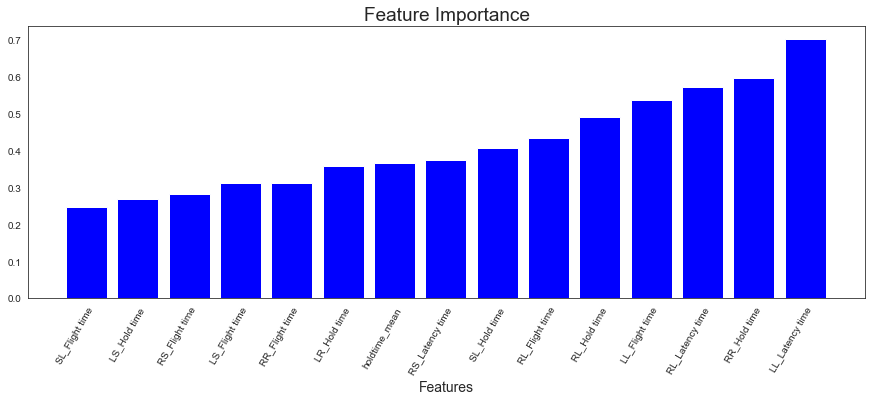

In [123]:
print(features)
plot_coefficients_absolute(clf_lr, features)

In [ ]:
features

In [124]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_movies,color='darkorange')
    plt.xlabel('Algorithm', fontsize=5)
    plt.ylabel('Accuracy', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Accuracy Comparison of Machine Learning Models')
    plt.show()

In [125]:
import matplotlib.pyplot as plt
import numpy as np

label = ['Statistical','LogisticRegression','RandomForest','LinearSVC']
no_movies = [
    0.658,
    0.757,
    0.697,
    0.727
]

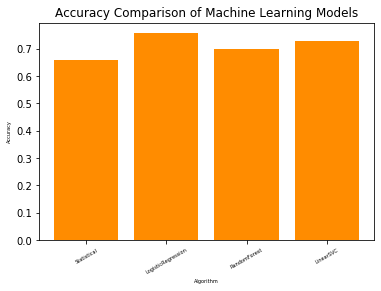

In [126]:
plot_bar_x()

In [127]:
def plot_bar_y():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, no_movies)
    plt.xlabel('Parkinsons', fontsize=5)
    plt.ylabel('Number of Participants', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title('Number of Participants That Have Parkinsons')
    plt.show()

In [128]:
import matplotlib.pyplot as plt
import numpy as np

label = ['0','1']
no_movies = [
    55,
    162
]

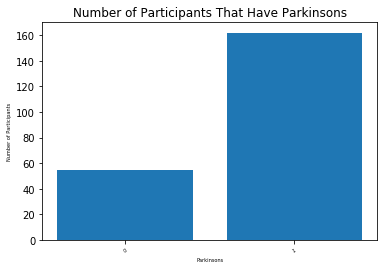

In [129]:
plot_bar_y()